<a href="https://colab.research.google.com/github/joangog/object-detection/blob/main/coco2017_inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Model comparison on COCO 2017 dataset (Inference)

The following models will be compared:

| Model | Backbone | Image Size | Parameters | GFLOPS 
| --- | --- | --- | --- | --- |
| SSD300 | VGG16 | 300x300 | 35.6M | 69.8 |
| SSDlite320 | MobileNetV3-Large | 320x320 | 3.4M | 1.2 |
| Faster R-CNN |  ResNet-50 FPN || 41.8M |  |
| Faster R-CNN |  MobileNetV3-Large FPN || 19.4M |  |
| Mask R-CNN |  ResNet-50 FPN || 44.4M | |
| YOLOv5s |  Custom | 640x640 | 7.3M | 17 |
| YOLOv5m |  Custom | 640x640 | 21.4M | 51.3 |
| YOLOv5l |  Custom |640x640 | 47M | 115.5 |
| YOLOv3 |  Darknet53 | 640x640 | 70M | 156.3 |
| YOLOv3-tiny |  Darknet53 | 640x640 | 8.8M | 13.3 |
| YOLOv3-spp |  Darknet53 | 640x640 | 63M | 157.1 |

<br>

*Note: GPU Runtime needed (ex. Tesla K80, 460.32.03, 11441 MiB)*




In [1]:
# Show system specs
!nvidia-smi --query-gpu=gpu_name,driver_version,memory.total --format=csv

name, driver_version, memory.total [MiB]
Tesla K80, 460.32.03, 11441 MiB


### Get requirements

In [2]:
%%shell

# Install Yolov5
cd /content
git clone https://github.com/ultralytics/yolov5
cd yolov5
pip install --quiet -r requirements.txt

Cloning into 'yolov5'...
remote: Enumerating objects: 9008, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 9008 (delta 21), reused 25 (delta 14), pack-reused 8963
Receiving objects: 100% (9008/9008), 9.46 MiB | 9.40 MiB/s, done.
Resolving deltas: 100% (6266/6266), done.
     |████████████████████████████████| 636 kB 4.3 MB/s 


In [3]:
%%shell

# Install Yolov3
cd /content
git clone https://github.com/ultralytics/yolov3
cd yolov3
pip install --quiet -r requirements.txt

Cloning into 'yolov3'...
remote: Enumerating objects: 9862, done.
remote: Total 9862 (delta 0), reused 0 (delta 0), pack-reused 9862
Receiving objects: 100% (9862/9862), 9.19 MiB | 7.52 MiB/s, done.
Resolving deltas: 100% (6666/6666), done.


In [4]:
%%shell

# Install flops-counter
pip install ptflops
pip install thop

  Created wheel for ptflops: filename=ptflops-0.6.6-py3-none-any.whl size=8903 sha256=ec1b374ad65c6d8d28724fa3de25f98b39db52782e0a286f2ec53097636f8142
  Stored in directory: /root/.cache/pip/wheels/eb/7c/e5/2332373fcac1b39ba9eb95698ac370da3e14eaba5516e22721
Successfully built ptflops


In [5]:
%%shell

# Clone asset files
cd /content
git clone https://github.com/joangog/object-detection-assets
cd object-detection-assets
mv assets ../
rm -rf /content/object-detection-assets/

Cloning into 'object-detection-assets'...
remote: Enumerating objects: 14, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 14 (delta 2), reused 11 (delta 2), pack-reused 0
Unpacking objects: 100% (14/14), done.


### Import packages

In [66]:
# Import packages

from google.colab import files
from google.colab import drive

import os, sys
import math
import time
import copy

import numpy as np
import pandas as pd
import json
import PIL

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torchvision
import torchvision.models.detection as M
import torchvision.transforms.functional as F
import torchvision.utils as U
from torchvision.datasets import CocoDetection

from ptflops import get_model_complexity_info

import assets.utils as AU
import assets.transforms as AT
import assets.coco_utils as ACU
from assets.coco_eval import CocoEvaluator

### Define auxiliary functions

In [75]:
# Copied and adjusted from repo pytorch/vision/references/detection/engine.py
def _get_iou_types(model):
    model_without_ddp = model
    if isinstance(model, torch.nn.parallel.DistributedDataParallel):
        model_without_ddp = model.module
    iou_types = ["bbox"]
    if isinstance(model_without_ddp, M.MaskRCNN):
        iou_types.append("segm")
    if isinstance(model_without_ddp, M.KeypointRCNN):
        iou_types.append("keypoints")
    return iou_types


# Copied and adjusted from repo pytorch/vision/references/detection/engine.py
@torch.no_grad()
def evaluate(model, data_loader, device):
    n_threads = torch.get_num_threads()
    torch.set_num_threads(1)
    cpu_device = torch.device("cpu")
    model.eval()
    metric_logger = AU.MetricLogger(delimiter="  ")
    header = 'Test:'
    coco = ACU.get_coco_api_from_dataset(data_loader.dataset)
    iou_types = _get_iou_types(model)
    coco_evaluator = CocoEvaluator(coco, iou_types)

    # Get label names
    label_ids = data_loader.dataset.coco.getCatIds()
    label_info = data_loader.dataset.coco.loadCats(label_ids)
    label_names = [label['name'] for label in label_info]
    labels = dict(zip(label_ids,label_names))  # Label dictionary with id-name as key-value
    labels_inv = dict(zip(label_names,label_ids))  # Inverse label dictionary with name-id as key-value

    for images, targets in metric_logger.log_every(data_loader, 100, header):
        
        images = list(img.to(device) for img in images)
        if model.__class__.__name__ == 'AutoShape':  # If model is from YOLOv5 package
          images = [F.to_pil_image(image) for image in images]  # Convert images from tensor to PIL

        if torch.cuda.is_available():
            torch.cuda.synchronize()
      
        model_time = time.time()      
        outputs = model(images)  # Get model predictions
        model_time = time.time() - model_time

        if model.__class__.__name__ == 'AutoShape':  # If model is from YOLO package
          # Format outputs to COCO format
          outputs_formatted = []
          for img_outputs in outputs.xyxy:
            output_bboxes = img_outputs[:,:4]
            output_scores = img_outputs[:,4]
            output_labels = img_outputs[:,5].to(cpu_device).apply_(lambda x: labels_inv[label_names[int(x)]]) # Convert YOLO label ids to COCO label ids
            outputs_formatted.append({
                'boxes': output_bboxes,
                'scores': output_scores,
                'labels': output_labels
            })
          outputs = outputs_formatted

        outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]

        # test lines #######################

        # label_ids = dataset.coco.getCatIds()
        # label_info = dataset.coco.loadCats(label_ids)
        # label_names = [label['name'] for label in label_info]
        # labels = dict(zip(label_ids,label_names))

        # img = F.convert_image_dtype(images[1],torch.uint8).cpu()
        
        # true_bboxes = F.Tensor([obj['bbox'] for obj in targets[1]]).cpu()
        # true_labels = [labels[obj['category_id']] for obj in targets[1]]
        # true_img = U.draw_bounding_boxes(img, true_bboxes, true_labels)
        # plt.figure(figsize = (25,7))
        # plt.imshow(F.to_pil_image(true_img))

        # output = outputs[1]
        # pred_bboxes = torch.stack([output['boxes'][i] for i in range(0,len(output['boxes'])) if output['scores'][i] > th])
        # pred_labels_ids = output['labels'].tolist()
        # pred_label_ids = [pred_labels_ids[i] for i in range(0,len(pred_labels_ids)) if output['scores'][i] > rh]  
        # pred_labels = [labels[label_id] for label_id in pred_label_ids]
        # pred_img = U.draw_bounding_boxes(img, pred_bboxes, pred_labels)
        # plt.figure(figsize = (25,7))
        # plt.imshow(F.to_pil_image(pred_img))

        # fig()

        ###############

        res = {target[0]["image_id"]: output for target, output in zip(targets, outputs) if len(target)!=0}
        evaluator_time = time.time()
        coco_evaluator.update(res)
        evaluator_time = time.time() - evaluator_time
        metric_logger.update(model_time=model_time, evaluator_time=evaluator_time)

    metric_logger.synchronize_between_processes()
    print("Averaged stats:", metric_logger)
    coco_evaluator.synchronize_between_processes()

    coco_evaluator.accumulate()
    coco_evaluator.summarize()
    torch.set_num_threads(n_threads)

    return coco_evaluator, model_time, evaluator_time, outputs

def convert_to_xyxy(bboxes):  # formats bboxes from (x,y,w,h) to (x,y,x,y)
  for bbox in bboxes:
    bbox[2] = bbox[0] + bbox[2]
    bbox[3] = bbox[1] + bbox[3]
  return bboxes


### Download COCO 2017 dataset

In [8]:
%%shell

# Download images
cd /content
wget 'http://images.cocodataset.org/zips/val2017.zip'
unzip -q 'val2017.zip'
rm 'val2017.zip'

--2021-08-22 15:33:20--  http://images.cocodataset.org/zips/val2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.28.220
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.28.220|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 815585330 (778M) [application/zip]
Saving to: ‘val2017.zip’

val2017.zip         100%[===================>] 777.80M  16.4MB/s    in 49s     

2021-08-22 15:34:10 (15.8 MB/s) - ‘val2017.zip’ saved [815585330/815585330]



In [9]:
%%shell

# Download annotations
cd /content
wget 'http://images.cocodataset.org/annotations/annotations_trainval2017.zip'
unzip -q 'annotations_trainval2017.zip'
rm 'annotations_trainval2017.zip'
cp '/content/annotations/instances_val2017.json' '/content/val2017'

--2021-08-22 15:34:16--  http://images.cocodataset.org/annotations/annotations_trainval2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.84.60
Connecting to images.cocodataset.org (images.cocodataset.org)|52.217.84.60|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252907541 (241M) [application/zip]
Saving to: ‘annotations_trainval2017.zip’

annotations_trainva 100%[===================>] 241.19M  16.5MB/s    in 16s     

2021-08-22 15:34:33 (14.9 MB/s) - ‘annotations_trainval2017.zip’ saved [252907541/252907541]



### Load COCO 2017 dataset

In [20]:
img_dir = '/content/val2017'
ann_file = os.path.join(img_dir,'instances_val2017.json')  # annotations

# Define data transforms
transforms = AT.Compose([AT.ToTensor()]) # Compose([Resize((640,640)), ToTensor()])

# Create dataset
dataset = CocoDetection(img_dir, ann_file, transforms = transforms)

# test
# for ann_id in dataset.coco.anns:
  # dataset.coco.anns[ann_id]['bbox'] = test_format_bbox(dataset.coco.anns[ann_id]['bbox'])

# Create data loader
data_loader = torch.utils.data.DataLoader(dataset, batch_size=2, shuffle=False, num_workers=2, collate_fn=AU.collate_fn)

loading annotations into memory...
Done (t=0.83s)
creating index...
index created!


### Load pre-trained model

In [77]:
%cd /content

''' If you get the error: 
    "Cache may be out of date, try 'force_reload=True'"
    then restart runtime.
'''

# Delete utils package to reload it (if loaded), because YOLOv3 and YOLOv5 have
# the same name for it and it causes error
try:
  sys.modules.pop('utils')
except:
  pass

# @markdown Model Selection { display-mode: 'form', run: 'auto' }
model_name = 'YOLOv3-tiny' # @param ['SSD300 VGG16', 'SSDlite320 MobileNetV3-Large', 'Faster R-CNN ResNet-50 FPN', 'Faster R-CNN MobileNetV3-Large FPN', 'Mask R-CNN ResNet-50 FPN', 'YOLOv5s', 'YOLOv5m', 'YOLOv5l', 'YOLOv3', 'YOLOv3-tiny', 'YOLOv3-spp']

if model_name == 'SSD300 VGG16':
  model_id = 'ssd300_vgg16'
  model = M.ssd300_vgg16(pretrained=True, progress=True)
  model_img_size = (3,300,300)
elif model_name == 'SSDlite320 MobileNetV3-Large':
  model_id = 'ssdlite320_mobilenet_v3_large'
  model = M.ssdlite320_mobilenet_v3_large(pretrained=True, progress=True)
  model_img_size = (3,320,320)
elif model_name == 'Faster R-CNN ResNet-50 FPN':
  model_id = 'fasterrcnn_resnet50_fpn'
  model = M.fasterrcnn_resnet50_fpn(pretrained=True, progress=True)
  model_img_size = (3,1333,1333) 
elif model_name == 'Faster R-CNN MobileNetV3-Large FPN':
  model_id = 'fasterrcnn_mobilenet_v3_large_fpn'
  model = M.fasterrcnn_mobilenet_v3_large_fpn(pretrained=True, progress=True)
  model_img_size = (3,224,224) 
elif model_name == 'Mask R-CNN ResNet-50 FPN':
  model_id = 'maskrcnn_resnet50_fpn'
  model = M.maskrcnn_resnet50_fpn(pretrained=True, progress=True)
  model_img_size = (3,224,224)
elif model_name == 'YOLOv5s':
  model_id = 'yolov5s'
  model = torch.hub.load('ultralytics/yolov5', 'yolov5s')
  model_img_size = (3,640,640)
elif model_name == 'YOLOv5m':
  model_id = 'yolov5m'
  model = torch.hub.load('ultralytics/yolov5', 'yolov5m')
  model_img_size = (3,640,640)
elif model_name == 'YOLOv5l':
  model_id = 'yolov5l'
  model = torch.hub.load('ultralytics/yolov5', 'yolov5l')
  model_img_size = (3,640,640)
elif model_name == 'YOLOv3':
  model_id = 'yolov3'
  model = torch.hub.load('ultralytics/yolov3', 'yolov3')
  model_img_size = (3,640,640)
elif model_name == 'YOLOv3-tiny':
  model_id = 'yolov3_tiny'
  model = torch.hub.load('ultralytics/yolov3', 'yolov3_tiny')
  model_img_size = (3,640,640)
elif model_name == 'YOLOv3-spp':
  model_id = 'yolov3_spp'
  model = torch.hub.load('ultralytics/yolov3', 'yolov3_spp')
  model_img_size = (3,640,640)

print('-------------------------------------------------------------------------------------------------------\n')

print(f'Loaded model: {model_name}')
model_params = sum([param.numel() for param in model.parameters()])
print(f'\t- Parameters: {round(model_params / 1000000, 1)}M')
model_macs, _ = get_model_complexity_info(model, model_img_size, as_strings=False, 
                                          print_per_layer_stat=False, verbose=False)
model_flops = 2 * int(model_macs)
print(f'\t- GFLOPS: {round(model_flops / 1000000000, 1)}')

/content
requirements: PyYAML>=5.3.1 not found and is required by YOLOv3, attempting auto-update...


Using cache found in /root/.cache/torch/hub/ultralytics_yolov3_master
Fusing layers... 



requirements: 1 package updated per /root/.cache/torch/hub/ultralytics_yolov3_master/requirements.txt
requirements: ⚠️ Restart runtime or rerun command for updates to take effect



Model Summary: 48 layers, 8849182 parameters, 0 gradients
Adding AutoShape... 
YOLOv3 🚀 2021-8-22 torch 1.9.0+cu102 CUDA:0 (Tesla K80, 11441.1875MB)



-------------------------------------------------------------------------------------------------------

Loaded model: YOLOv3-tiny
	- Parameters: 8.8M
	- GFLOPS: 13.3


### (Optional) Test model with image sample

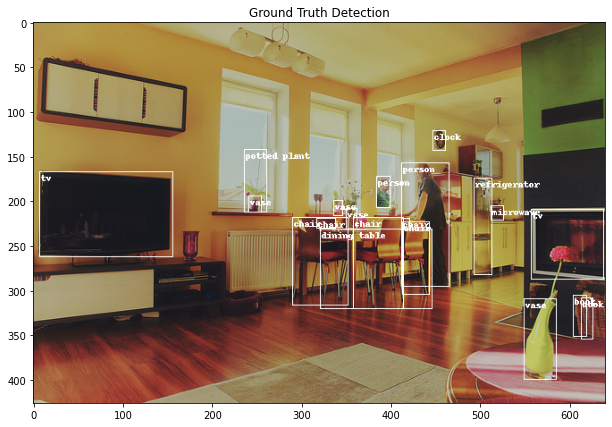

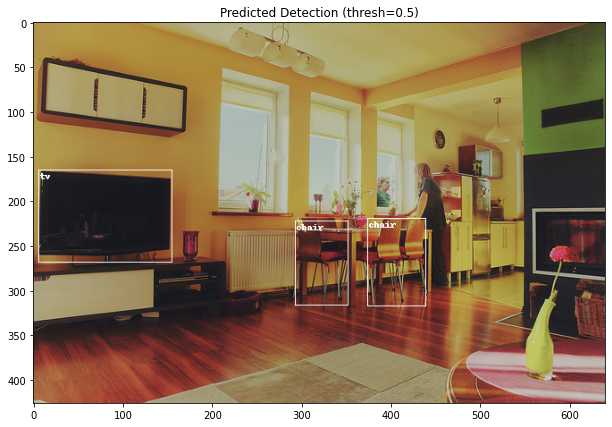

In [78]:
# Parameters
img_id = 139 #11051 # 67406
th = 0.5  # threshold for confidence score of predicted bboxes to show

# Get appropriate device for model
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Get image sample
img = PIL.Image.open(os.path.join(img_dir,dataset.coco.loadImgs([img_id])[0]['file_name']))
img_tensor = F.convert_image_dtype(F.to_tensor(img),torch.uint8)
img_torchvision = torch.div(img_tensor,255).float().to(device)  # Format image for torchvision models
img_anns = dataset.coco.loadAnns(dataset.coco.getAnnIds([img_id]))

# Generate model predictions
model.eval()
with torch.no_grad():
  if 'YOLO' in model_name:
    pred = model([img])
  else:    
    pred = model([img_torchvision])

# Get label names
label_ids = dataset.coco.getCatIds()
label_info = dataset.coco.loadCats(label_ids)
label_names = [label['name'] for label in label_info]
labels = dict(zip(label_ids,label_names))  # Label dictionary with id-name as key-value
labels_inv = dict(zip(label_names,label_ids))  # Inverse label dictionary with name-id as key-value

# Get ground truth bboxes
true_bboxes = convert_to_xyxy(copy.deepcopy(F.Tensor([obj['bbox'] for obj in img_anns]).to(device)))  # Create deep copy to avoid updating original dataset
true_labels = [labels[obj['category_id']] for obj in img_anns]
true_img = U.draw_bounding_boxes(img_tensor, true_bboxes, true_labels)
plt.figure(figsize = (25,7))
plt.title('Ground Truth Detection')
plot = plt.imshow(F.to_pil_image(true_img))

# Get ground truth segmentation masks
# print(img_anns)
# true_masks = F.Tensor([obj['segmentation'][0] for obj in img_anns])
# true_labels = [labels[obj['category_id']] for obj in img_anns]
# true_img = U.draw_segmentation_masks(img, true_masks, true_labels)
# plt.figure(figsize = (25,7))
# plt.imshow(F.to_pil_image(true_img))

# Get predicted bboxes
# For YOLO models
if 'YOLO' in model_name:  
  pred_bboxes = []
  pred_labels = []
  for img in pred.xyxy:
    for bbox in img:
      if bbox[4] > th:  # Show only bboxes with high confidence score
        pred_bboxes.append(bbox[:4])
        pred_labels.append(labels[labels_inv[label_names[int(bbox[5])]]])  # Convert YOLO label to COCO label
  pred_bboxes = torch.stack(pred_bboxes)
# For torchvision models
else:
  pred_bboxes = torch.stack([pred[0]['boxes'][i] for i in range(0,len(pred[0]['boxes'])) if pred[0]['scores'][i] > th])  # Show only bboxes with high confidence score
  pred_labels_ids = torch.stack([pred[0]['labels'][i] for i in range(0,len(pred[0]['labels'])) if pred[0]['scores'][i] > th]).tolist()
pred_img = U.draw_bounding_boxes(img_tensor, pred_bboxes, pred_labels)
plt.figure(figsize = (25,7))
plt.title(f'Predicted Detection (thresh={th})')
plot = plt.imshow(F.to_pil_image(pred_img))

### Evaluate model on dataset

In [79]:
# Get appropriate device for model
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)
print(f'Model: {model_name}')

# Evaluate model
evaluator, model_time, evaluator_time, outputs = evaluate(model, data_loader, device)



Model: YOLOv3-tiny
Test:  [   0/2500]  eta: 0:13:30  model_time: 0.0516 (0.0516)  evaluator_time: 0.0181 (0.0181)  time: 0.3241  data: 0.1963  max mem: 393
Test:  [ 100/2500]  eta: 0:03:16  model_time: 0.0411 (0.0441)  evaluator_time: 0.0079 (0.0091)  time: 0.0798  data: 0.0033  max mem: 393
Test:  [ 200/2500]  eta: 0:03:03  model_time: 0.0424 (0.0439)  evaluator_time: 0.0070 (0.0088)  time: 0.0764  data: 0.0035  max mem: 393
Test:  [ 300/2500]  eta: 0:02:54  model_time: 0.0459 (0.0438)  evaluator_time: 0.0089 (0.0088)  time: 0.0798  data: 0.0036  max mem: 393
Test:  [ 400/2500]  eta: 0:02:46  model_time: 0.0404 (0.0437)  evaluator_time: 0.0080 (0.0088)  time: 0.0782  data: 0.0041  max mem: 393
Test:  [ 500/2500]  eta: 0:02:37  model_time: 0.0419 (0.0437)  evaluator_time: 0.0079 (0.0086)  time: 0.0787  data: 0.0036  max mem: 393
Test:  [ 600/2500]  eta: 0:02:29  model_time: 0.0423 (0.0437)  evaluator_time: 0.0080 (0.0086)  time: 0.0775  data: 0.0036  max mem: 393
Test:  [ 700/2500]  et

## Save results

In [72]:
cols = ['model', 'model_params', 'model_time', 'iou_type', 'metric', 'iou', 'area', 'max_dets', 'score']
model = []
model_params_arr = []
model_time_arr = []
iou_type = []
metric = []
iou = []
area = []
max_dets = []
score = []

# Set column values
for curr_iou_type, coco_eval in evaluator.coco_eval.items():
  model += [model_name for i in range(0,12)]
  model_params_arr += [model_params for i in range(0,12)]
  model_time_arr += [model_time for i in range(0,12)]
  iou_type += [curr_iou_type for i in range(0,12)]
  metric += ['avg_precision' for i in range(0,6)] + ['avg_recall' for i in range(0,6)]
  iou += ['0.50:0.95', '0.50 ', '0.75'] + ['0.50:0.95' for i in range(0,9)]
  area += ['all' for i in range(0,3)] + ['small', 'medium', 'large'] + ['all' for i in range(0,3)] + ['small', 'medium', 'large'] 
  max_dets += [100 for i in range(0,6)] + [1, 10] + [100 for i in range(0,4)]
  score += list(coco_eval.stats)

results = pd.DataFrame(np.column_stack([model, model_params_arr, model_time_arr, iou_type, metric, iou, area, max_dets, score]))
results.columns = cols

# Safe file
results_file = f'{model_id}_coco17_results.csv'
results_dir = '/content'
results_path = os.path.join(results_dir, results_file)
if os.path.exists(results_path):
      os.remove(results_path)
with open(results_path, 'w') as outfile: 
    results.to_csv(outfile)

In [73]:
# Save file to GDrive
drive.mount('/content/drive')
gdrive_results_dir = '/content/drive/MyDrive/object-detection-outputs/COCO2017'
gdrive_results_path = os.path.join(gdrive_results_dir, results_file)
if os.path.exists(gdrive_results_path):
      os.remove(gdrive_results_path)
with open(gdrive_results_path, 'w') as outfile: 
    results.to_csv(outfile)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [74]:
# results = []
# for i, img_id in enumerate(img_ids):  # For every image
#   img_predictions = predictions[i]
#   pred_boxes = img_predictions['boxes'].tolist()
#   pred_labels = img_predictions['labels'].tolist()
#   pred_scores = img_predictions['scores'].tolist()
#   for j in range(0,len(pred_box)):  # For every predicted object
#     pred_box = pred_boxes[j]
#     results.append({
#         'image_id': img_id,
#         'category_id': pred_labels[j],
#         'bbox': [round(val,1) for val in pred_box],  # Round for lower file size
#         'score': pred_scores[j]
#         })

# results_file = os.path.join(img_dir,f'{model_id}_coco17_results.json')
# with open(results_file, 'w') as outfile: 
#     json.dump(results, outfile,indent = 2)